In [1]:
import numpy as np
import torch
import pyro
import torch.distributions as dist
import pyro.distributions as pdist
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyro import poutine

from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer import NUTS, MCMC
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import poutine
from torch.distributions import constraints
from pyro.ops.indexing import Vindex

In [21]:
torch.set_default_tensor_type("torch.cuda.DoubleTensor")

### Target

$transition = [0.1, 0.7]$ <br>
$emission = [0.9, 0.6]$

In [29]:
def hmm_target(z0, T_seq, T_bseq, K):
    '''
    - ``t_seq`` -- general sequence length
    i.e. global time
    
    - ``T_bseq`` -- length of sequence in each batch
    (must divide `t_seq`) i.e. local time
    
    - ``K`` -- count of sequences in each batch
    
    Return:
    containing batchs tensor of shape:
    T_seq/T_bseq, T_bseq, K
    '''
    z_prev = z0 * torch.ones(K)
    
    x_batch = torch.tensor([])
    z_batch = torch.tensor([])
    transition = torch.tensor([0.1, 0.7])
    emission = torch.tensor([0.9, 0.6])
    for i in range(int(T_seq/T_bseq)):
        zs = torch.tensor([])
        xs = torch.tensor([])
        with pyro.plate("plate0", K):
            for t in range(T_bseq):
                # j = K - i % K
                # z.shape == K
                ip_transition = Vindex(transition)[z_prev.type(torch.long)]
                z = pyro.sample("z_%d" % t,
                                pdist.Binomial(1, ip_transition))
                               
                z_prev = z
                # print(ip_transition)
                # print(z)
                ip_emission = Vindex(emission)[z.type(torch.long)]
                x = pyro.sample("x_%d" % t,
                                pdist.Binomial(1, ip_emission))
                # zs.shape will be (after for loop) (K, T_bseq)
                zs = torch.cat([zs,
                                torch.unsqueeze(z, 0)], 0)
                xs = torch.cat([xs,
                                torch.unsqueeze(x, 0)], 0)
        
        # z_batch.shape will be (after for loop) (T_seq/T_bseq, )       
        x_batch = torch.cat([x_batch, torch.unsqueeze(xs.T, 0)], 0)
        z_batch = torch.cat([z_batch, torch.unsqueeze(zs.T, 0)], 0)
    
    print("\nz.shape:")
    print(z.shape)
    print("\nzs.shape:")
    print(zs.shape)
    print("\nz_batch.shape:")
    print(z_batch.shape) 
    return(x_batch, z_batch)

In [36]:
xs_batch, zs_batch = hmm_target(1, 1800, 100, 20)


z.shape:
torch.Size([20])

zs.shape:
torch.Size([100, 20])

z_batch.shape:
torch.Size([18, 20, 100])


### Condition:

In [31]:
def hmm_cond(xs_batch):
  '''Condition x on observed data (xs_batch) 
  - ``xs_batch`` -- shape must looks like:
  (seqs, time)
    
  Because of usage of plate all seqs[t] will be sampled
  at once (for fixed t).
    
  x.shape == z0.shape == Size([K])
  where K is count of seqs in batch (xs_batch.shape[0])
  '''
  T = xs_batch.shape[1]
  z0 = xs_batch[:, 0]
  # p_z_z_0 = pyro.param("p(z=1|z_prev=0)", pdist.Uniform(0, 0.9), constraint=constraints.interval(0, 0.9))
  # p_z_z_1 = pyro.param("p(z=1|z_prev=1)", pdist.Uniform(0, 0.9), constraint=constraints.interval(0, 0.9))
        
  # p_x_z_0 = pyro.param("p(x=1|z=0)")
  # p_x_z_1 = pyro.param("p(x=1|z=1)")
  # goal: torch.tensor([0.1, 0.7])
  p_transition = pyro.sample("transition", pdist.Dirichlet(0.5*torch.ones(2)))
  p_emission = pyro.sample("emission", pdist.Dirichlet(0.5*torch.ones(2)))     
  with pyro.plate("plate3", xs_batch.shape[0], use_cuda=True) as ind:
    z_prev = z0
    for t in pyro.markov(range(1, T)):
      # for t in range(1, T):
      
      # p_transition = torch.tensor([0.1, 0.1])
      # p_transition = torch.tensor([p_z_z_0, p_z_z_1])
      ip_transition = Vindex(p_transition)[z_prev.type(torch.long)]
      z = pyro.sample("z_%d" % t, pdist.Binomial(1, ip_transition),
                      infer={"enumerate": "parallel"},
                      ).to("cuda")
      z_prev = z
      
      # p_emission = torch.tensor([0.9, 0.6])
      # p_emission = torch.tensor([p_x_z_0, p_x_z_1])
      ip_emission = Vindex(p_emission)[z.type(torch.long)]
      x = pyro.sample("x_%d" % t, pdist.Binomial(1, ip_emission),
                      infer={"enumerate": "parallel"},
                      obs=xs_batch[:, t])
  # print(z)
  # print(xs_batch[:,t])


In [47]:
print(xs_batch[0].shape)
hmm_cond(xs_batch[0])

torch.Size([20, 100])


In [38]:
# xs_batch.to("cuda");
xs_batch.shape

torch.Size([18, 20, 100])

### Inference

In [44]:
nuts_kernel = NUTS(hmm_cond)

mcmc = MCMC(nuts_kernel, num_samples=170)
# for x_batch in xs_batch[:3]:
mcmc.run(x_batch)
# mcmc = MCMC(nuts_kernel, num_samples=100)
# mcmc.run(data[:100])
# mcmc.run(data[:30], 2)
samples = mcmc.get_samples()


Sample: 100%|██████████| 140/140 [10:35,  4.54s/it, step size=2.91e-01, acc. prob=0.908]


In [48]:
print(len(samples['transition']))
print(samples['transition'][-1])
print(samples['emission'][-1])
mcmc.summary()


70
tensor([0.0180, 0.9820])
tensor([0.8429, 0.1571])

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
transition[0]      0.02      0.00      0.02      0.01      0.03     53.04      0.99
transition[1]      0.98      0.00      0.98      0.97      0.99     53.04      0.99
  emission[0]      0.84      0.01      0.84      0.83      0.85     19.25      1.00
  emission[1]      0.16      0.01      0.16      0.15      0.17     19.25      1.00

Number of divergences: 0


In [46]:
torch.cuda.empty_cache()

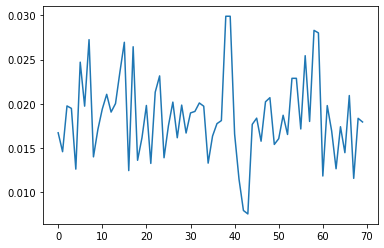

In [52]:
plt.plot(samples['transition'].cpu().numpy()[:,0])

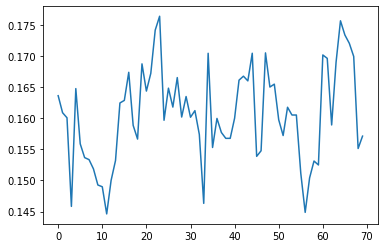

In [54]:
plt.plot(samples['emission'].cpu().numpy()[:,1])